In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle


In [2]:
data = pd.read_csv('data/red_gpt_resps.csv')

In [3]:
data.isnull().value_counts()

Unnamed: 0  title  text   ai_generated
False       False  False  False           9802
dtype: int64

In [4]:
X = data['text']
y = data['ai_generated']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

## First Model

In [121]:
cvec_mnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [9]:
nltk_stop = stopwords.words('english')

In [120]:
cvec_params = {
    'cvec__max_features' : [2000, 4000],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : ['english', None, nltk_stop]
}

In [32]:
gs = GridSearchCV(cvec_mnb_pipe, # what object are we optimizing?
                  cvec_params, # what parameters values are we searching?
                  cv = 3, # 3-fold cross-validation.
                  error_score='raise') 

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_features': [2000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [34]:
gs.score(X_train, y_train)

0.8638280506053598

In [35]:
gs.score(X_test, y_test)

0.8494492044063647

In [102]:
gs.best_params_

{'cvec__max_features': 4000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

## Second Model

In [10]:
tvec_mnb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [11]:
tvec_params = {
    'tvec__max_features' : [1000, 3000],
    'tvec__ngram_range' : [(1,1), (1, 2)],
    'tvec__stop_words' : ['english', None, nltk_stop]
}

In [12]:
gs2 = GridSearchCV(tvec_mnb_pipe, 
                  tvec_params, 
                  cv = 3, 
                  error_score='raise') 

In [13]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_features': [1000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [28]:
gs2.score(X_train, y_train)

0.8874982995510815

In [29]:
gs2.score(X_test, y_test)

0.8657690738474092

In [103]:
gs2.best_params_

{'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [43]:
gs2.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

In [44]:
with open('./models/tvec_mnb_pipe.pkl', 'wb') as f:
    pickle.dump(gs2.best_estimator_, f)

In [14]:
# Get predictions
preds2 = gs2.predict(X_test)
# Save confusion matrix values
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

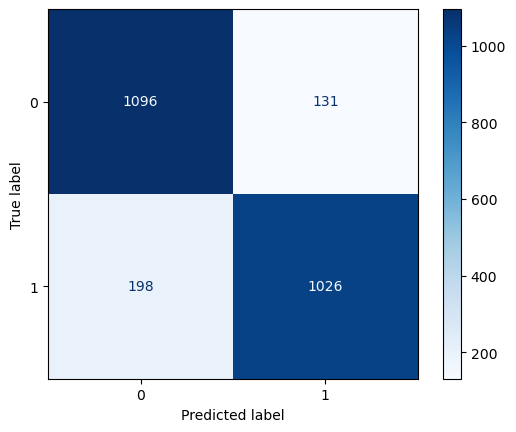

In [53]:
cmtx2 = ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx2.png')

In [61]:
(tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)

0.8657690738474092

## Third Model

In [16]:
cvec_logr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
])

cvec_logr_params = {
    'cvec__max_features' : [2000, 4000],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : ['english', None, nltk_stop],
    'logr__max_iter' : [500]
}

In [17]:
gs3 = GridSearchCV(cvec_logr_pipe, 
                  cvec_logr_params, 
                  cv = 3) 

In [18]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'cvec__max_features': [2000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'logr__max_iter': [500]})

In [53]:
gs3.score(X_train, y_train)

0.9780982179295334

In [54]:
gs3.score(X_test, y_test)

0.8804569563443493

Very overfit

In [104]:
gs3.best_params_

{'cvec__max_features': 4000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logr__max_iter': 500}

In [45]:
with open('./models/cvec_logr_pipe.pkl', 'wb') as f:
    pickle.dump(gs3.best_estimator_, f)

In [19]:
# Get predictions
preds3 = gs3.predict(X_test)
# Save confusion matrix values
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, preds3).ravel()

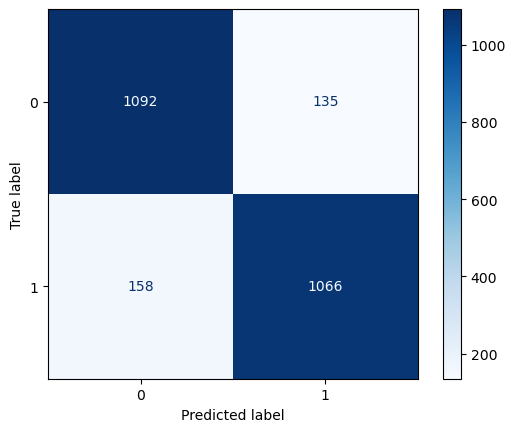

In [54]:
cmtx3 = ConfusionMatrixDisplay.from_estimator(gs3, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx3.png')

## Fourth Model

In [130]:
cvec_bnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),

    ('bnb', BernoulliNB())
])

cvec_bnb_params = {
    'cvec__max_features' : [2000, 4000],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : ['english', None, nltk_stop],
    'bnb__alpha' : [0.5, 0.75]
}

In [131]:
gs4 = GridSearchCV(cvec_bnb_pipe, 
                  cvec_bnb_params, 
                  cv = 5) 

In [132]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'bnb__alpha': [0.5, 0.75],
                         'cvec__max_features': [2000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [133]:
gs4.score(X_train, y_train)

0.7205822337096993

In [134]:
gs4.score(X_test, y_test)

0.729906160750714

In [105]:
gs4.best_params_

{'bnb__alpha': 0.5,
 'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

## Fifth Model

In [116]:
tvec_gnb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svd', TruncatedSVD()),
    ('gnb', GaussianNB())
])

gs5 = GridSearchCV(tvec_gnb_pipe, 
                  tvec_params, 
                  cv = 3) 

In [71]:
gs5.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svd', TruncatedSVD()),
                                       ('gnb', GaussianNB())]),
             param_grid={'tvec__max_features': [1000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [74]:
gs5.score(X_train, y_train)

0.6645354373554618

In [76]:
gs5.score(X_test, y_test)

0.6699306405548756

In [106]:
gs5.best_params_

{'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

## Sixth Model

In [22]:

tvec_lsvc_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lsvc', LinearSVC(dual='auto'))
])

tvec_lsvc_params = {
    'tvec__max_features' : [3000],
    'tvec__ngram_range' : [(1, 2)],
    'tvec__stop_words' : [None],
    'lsvc__max_iter' : [5000],
    'lsvc__C' : [2.63231579e-01]
}
gs6 = GridSearchCV(tvec_lsvc_pipe, 
                  tvec_lsvc_params, 
                  cv = 3) 

# Originally ran the Grdisearch below. But based on best parameters ran the code above.

# tvec_lsvc_pipe = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('lsvc', LinearSVC(dual='auto'))
# ])

# tvec_lsvc_params = {
#     'tvec__max_features' : [1000, 3000],
#     'tvec__ngram_range' : [(1,1), (1, 2)],
#     'tvec__stop_words' : ['english', None, nltk_stop],
#     'lsvc__max_iter' : [5000],
#     'lsvc__C' : [0.0001, 2.63231579e-01, 4.73736842e-0, 6.84242105e-01, 8.94747368e-01, 1.00000000e+00]
# }
# gs6 = GridSearchCV(tvec_lsvc_pipe, 
#                   tvec_lsvc_params, 
#                   cv = 3) 


In [23]:
gs6.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lsvc', LinearSVC(dual='auto'))]),
             param_grid={'lsvc__C': [0.263231579], 'lsvc__max_iter': [5000],
                         'tvec__max_features': [3000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]})

In [82]:
gs6.best_score_

0.8710377272083863

In [83]:
gs6.score(X_train, y_train)

0.9405523058087335

In [84]:
gs6.score(X_test, y_test)

0.8951448388412893

In [85]:
gs6.best_params_

{'lsvc__C': 0.263231579,
 'lsvc__max_iter': 5000,
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [99]:
gs6.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('tvec', TfidfVectorizer()),
  ('lsvc', LinearSVC(dual='auto'))],
 'estimator__verbose': False,
 'estimator__tvec': TfidfVectorizer(),
 'estimator__lsvc': LinearSVC(dual='auto'),
 'estimator__tvec__analyzer': 'word',
 'estimator__tvec__binary': False,
 'estimator__tvec__decode_error': 'strict',
 'estimator__tvec__dtype': numpy.float64,
 'estimator__tvec__encoding': 'utf-8',
 'estimator__tvec__input': 'content',
 'estimator__tvec__lowercase': True,
 'estimator__tvec__max_df': 1.0,
 'estimator__tvec__max_features': None,
 'estimator__tvec__min_df': 1,
 'estimator__tvec__ngram_range': (1, 1),
 'estimator__tvec__norm': 'l2',
 'estimator__tvec__preprocessor': None,
 'estimator__tvec__smooth_idf': True,
 'estimator__tvec__stop_words': None,
 'estimator__tvec__strip_accents': None,
 'estimator__tvec__sublinear_tf': False,
 'estimator__tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'estimator__tvec__tokenizer': None,

In [46]:
with open('./models/tvec_lsvc_pipe.pkl', 'wb') as f:
    pickle.dump(gs6.best_estimator_, f)

In [19]:
# Get predictions
preds6 = gs6.predict(X_test)
# Save confusion matrix values
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, preds6).ravel()

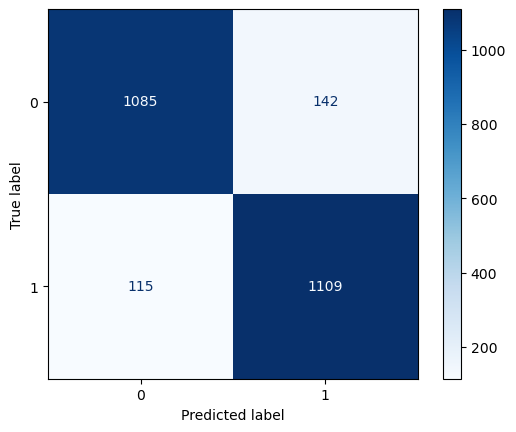

In [55]:
cmtx6 = ConfusionMatrixDisplay.from_estimator(gs6, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx6.png')

## Seventh Model

In [118]:
tvec_knn_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

tvec_knn_params = {
    'tvec__max_features' : [1000, 3000],
    'tvec__ngram_range' : [(1,1), (1, 2)],
    'tvec__stop_words' : ['english', None, nltk_stop],
    'knn__n_neighbors' : [1, 5, 10],
    'knn__weights' : ['uniform', 'distance']
}
gs7 = GridSearchCV(tvec_knn_pipe, 
                  tvec_knn_params, 
                  cv = 3) 

In [108]:
gs7.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 5, 10],
                         'knn__weights': ['uniform', 'distance'],
                         'tvec__max_features': [1000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [109]:
gs7.best_score_

0.5936600637807142

In [110]:
gs7.score(X_train, y_train)

0.9953747789416406

In [111]:
gs7.score(X_test, y_test)

0.6266829865361077

## Eighth Model

In [124]:
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

tvec_rf_params = {
    'tvec__max_features' : [1000, 3000],
    'tvec__ngram_range' : [(1,1), (1, 2)],
    'tvec__stop_words' : [None],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 3, 4, 5, 6, 7]
}
gs8 = GridSearchCV(tvec_rf_pipe, 
                  tvec_rf_params, 
                  cv = 3) 

In [125]:
gs8.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 3, 4, 5, 6, 7],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_features': [1000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None]})

In [126]:
gs8.best_score_

0.8798801544281524

In [127]:
gs8.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 100,
 'tvec__max_features': 3000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [128]:
gs8.score(X_train, y_train)

0.9971432458168956

In [129]:
gs8.score(X_test, y_test)

0.8792329661362709

## Ninth Model

In [36]:
cvec_lsvc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lsvc', LinearSVC(dual='auto'))
])

cvec_lsvc_params = {
    'cvec__max_features' : [2000, 4000],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : [None, nltk_stop],
    'lsvc__max_iter' : [7000],
    'lsvc__C' : [0.0001, 2.63231579e-01, 8.94747368e-01, 1.00000000e+00]
}
gs9 = GridSearchCV(cvec_lsvc_pipe, 
                  cvec_lsvc_params, 
                  cv = 3) 

In [37]:
gs9.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lsvc', LinearSVC(dual='auto'))]),
             param_grid={'cvec__max_features': [2000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]],
                         'lsvc__C': [0.0001, 0.263231579, 0.894747368, 1.0],
                         'lsvc__max_iter': [7000]})

In [145]:
gs9.score(X_train, y_train)

0.9676234525914842

In [146]:
gs9.score(X_test, y_test)

0.8694410444716443

In [47]:
with open('./models/cvec_lsvc_pipe.pkl', 'wb') as f:
    pickle.dump(gs9.best_estimator_, f)

In [38]:
# Get predictions
preds9 = gs9.predict(X_test)
# Save confusion matrix values
tn9, fp9, fn9, tp9 = confusion_matrix(y_test, preds9).ravel()

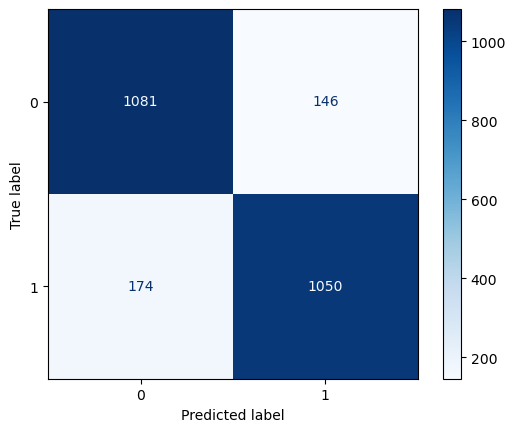

In [56]:
cmtx9 = ConfusionMatrixDisplay.from_estimator(gs9, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx9.png')

In [77]:
acc_9 = (tp9 + tn9) / (tp9 + tn9 + fp9 + fn9)
acc_9

0.8694410444716443

In [78]:
prec_9 = tp9 / (tp9 + fp9)
prec_9

0.8779264214046822

In [79]:
recall_9 = tp9 / (tp9 + fn9)
recall_9

0.8578431372549019

In [80]:
spec_9 = tn9 / (tn9 + fp9)
spec_9

0.8810105949470253

In [81]:
f1_9 = 2 * (prec_9 * recall_9) / (prec_9 + recall_9)
f1_9

0.8677685950413222

## Tenth model

In [59]:
# accidentally repeated this one. This is the same as the first model I ran.
cvec_mnb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [31]:
cvec_params = {
    'cvec__max_features' : [2000, 4000],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : [None, nltk_stop],
}

In [32]:
gs10 = GridSearchCV(cvec_mnb_pipe, 
                  cvec_params, 
                  cv = 3, 
                  error_score='raise') 

In [33]:
gs10.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_features': [2000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [151]:
gs10.score(X_train, y_train)

0.8638280506053598

In [152]:
gs10.score(X_test, y_test)

0.8494492044063647

In [48]:
with open('./models/cvec_mnb_pipe.pkl', 'wb') as f:
    pickle.dump(gs10.best_estimator_, f)

In [34]:
# Get predictions
preds10 = gs10.predict(X_test)
# Save confusion matrix values
tn10, fp10, fn10, tp10 = confusion_matrix(y_test, preds10).ravel()

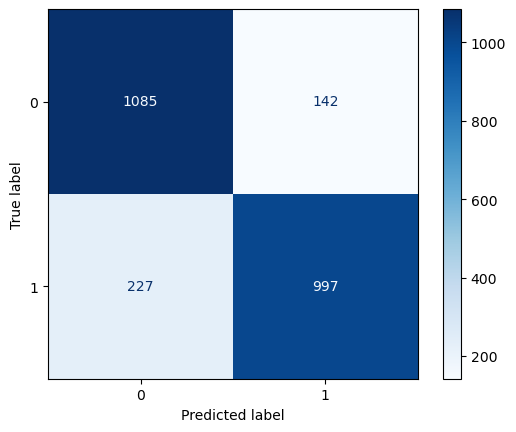

In [57]:
cmtx10 = ConfusionMatrixDisplay.from_estimator(gs10, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx10.png')

## Eleventh model

In [25]:
tvec_logr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegression())
])

tvec_logr_params = {
    'tvec__max_features' : [6000],
    'tvec__ngram_range' : [(1, 2)],
    'tvec__stop_words' : [None],
    'logr__max_iter' : [500]
}

# Originally ran the gridsearch with the params below. Used the params above to save time when rerunning.  
# tvec_logr_params = {
#     'tvec__max_features' : [2000, 4000, 6000],
#     'tvec__ngram_range' : [(1,1), (1, 2)],
#     'tvec__stop_words' : [None, nltk_stop],
#     'logr__max_iter' : [500, 700]
# }


In [26]:
gs11 = GridSearchCV(tvec_logr_pipe, 
                  tvec_logr_params, 
                  cv = 3) 

In [27]:
gs11.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             param_grid={'logr__max_iter': [500], 'tvec__max_features': [6000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [None]})

In [164]:
gs11.score(X_train, y_train)

0.9277649299415046

In [165]:
gs11.score(X_test, y_test)

0.8898408812729498

In [166]:
gs11.best_params_

{'logr__max_iter': 500,
 'tvec__max_features': 6000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [49]:
with open('./models/tvec_logr_pipe.pkl', 'wb') as f:
    pickle.dump(gs11.best_estimator_, f)

In [28]:
# Get predictions
preds11 = gs11.predict(X_test)
# Save confusion matrix values
tn11, fp11, fn11, tp11 = confusion_matrix(y_test, preds11).ravel()

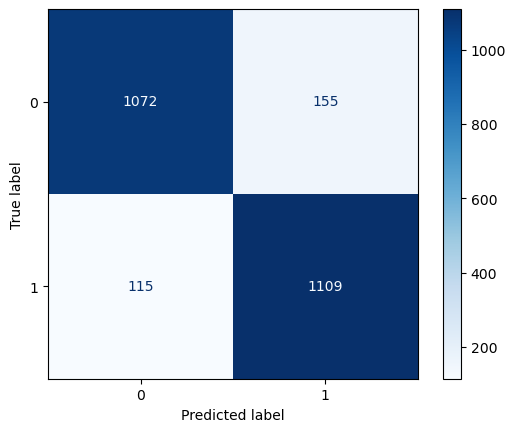

In [58]:
cmtx11 = ConfusionMatrixDisplay.from_estimator(gs11, X_test, y_test, cmap='Blues', values_format='d')
plt.savefig('./figures/cmtx11.png')

In [73]:
acc_11 = (tp11 + tn11) / (tp11 + tn11 + fp11 + fn11)
acc_11

0.8898408812729498

In [71]:
prec_11 = tp11 / (tp11 + fp11)
prec_11

0.877373417721519

In [72]:
recall_11 = tp11 / (tp11 + fn11)
recall_11

0.9060457516339869

In [76]:
spec_11 = tn11 / (tn11 + fp11)
spec_11

0.8736756316218419

In [70]:
f1_11 = 2 * (prec_11 * recall_11) / (prec_11 + recall_11)
f1_11

0.8914790996784566